<a href="https://colab.research.google.com/github/vksepm/hands-on-agentic-ai-building-ai-agents-with-llamaindex-3962125/blob/main/code_05_XX%20ReAct%20agent%20with%20Workflows%20-%20Doctor%20scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qU python-dotenv
!pip install -qU llama-index
!pip install -qU llama-index-llms-openai
!pip install -qU llama-index-embeddings-openai
!pip install -qU llama-index-llms-azure-openai
!pip install -qU llama-index-embeddings-azure-openai
!pip install -qU llama-index-agent-introspective
!pip install -qU llama-index-program-openai
!pip install -qU llama-index-readers-file
!pip install -qU pydantic
!pip install -qU llama-index-core
!pip install -qU llama-index-utils-workflow
!pip install -qU llama-index-tools-wikipedia
!pip install -qU llama-index-readers-json
!pip install -qU llama-index-readers-file
!pip install -qU pymupdf
!pip install -qU llama-index-tools-google
!pip install -qU nbformat
!pip install -qU arize-phoenix
!pip install -qU llama-index
!pip install -qU llama-index-callbacks-arize-phoenix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.3/251.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━

In [2]:
%%bash
git clone https://github.com/vksepm/hands-on-agentic-ai-building-ai-agents-with-llamaindex-3962125.git
mv ./hands-on-agentic-ai-building-ai-agents-with-llamaindex-3962125/* .
rm -rf ./hands-on-agentic-ai-building-ai-agents-with-llamaindex-3962125/

Cloning into 'hands-on-agentic-ai-building-ai-agents-with-llamaindex-3962125'...


### Setup LLM and Embedding

In [3]:
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.core import Settings
import os
import nest_asyncio
from google.colab import userdata
from IPython.display import Markdown, display

#Used by LlamaIndex
nest_asyncio.apply()

#Setup the environment variables
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('AZURE_OPENAI_ENDPOINT')
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('AZURE_OPENAI_API_KEY')
os.environ["OPENAI_API_VERSION"] = userdata.get('OPENAI_API_VERSION')

#Note : Function calling support only available in GPT-4+
#Create the LLM object
Settings.llm=AzureOpenAI(
    model="gpt-4o-mini",
    deployment_name="gpt-4o-mini",
    api_version="2024-08-01-preview",
)

#Set up the embedding model for RAG
Settings.embed_model= AzureOpenAIEmbedding(
    model="text-embedding-3-small",
    api_key=userdata.get('AZURE_OPENAI_API_KEY'),
    azure_endpoint=userdata.get('AZURE_OPENAI_ENDPOINT'),
    api_version="2023-05-15",
)

### 05.02. Setup Doctor database tool

In [4]:
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import  VectorStoreIndex
from llama_index.core.tools import QueryEngineTool
from llama_index.readers.json import JSONReader

doctor_docs = JSONReader().load_data(
        input_file="datasets/Doctors database.json"
)
#Split the document
splitter=SentenceSplitter(chunk_size=200)
doctor_nodes=splitter.get_nodes_from_documents(doctor_docs)

#Index the document in memory
doctor_index=VectorStoreIndex(doctor_nodes)

#Create a query engine tool based on the CSV file
doctor_query_engine = doctor_index.as_query_engine()
doctor_tool = QueryEngineTool.from_defaults(
    query_engine=doctor_query_engine,
    description=(
        """Provides the list of doctors,
            diseases they specialize in (or speciality),
            years of experience and
            their contact email Id to setup appointments"""
    ),
)

### 05.03. Setup scheduling tool

In [5]:
import datetime
import csv

def schedule_appointment(patient_name:str,
                         doctor_name:str,
                         scheduling_comments:str) -> bool :
    """
    This function is used to schedule a doctor appointment. It takes 3 inputs
    patient_name : The name of the patient for who the appointment is required.
    doctor_name : The name of the doctor to setup the appointment with.
    scheduling_comments: Additional information on requested date, time etc. for the appointment

    The function returns True if the appointment setup is successful. False otherwise.
    """
    #Capture current date and month
    requested_date = datetime.datetime.now().strftime("%b-%d")

    #Capture appointment details
    appointment_details = [requested_date,
                           patient_name,
                           doctor_name,
                           scheduling_comments]

    #Make sure that the file is closed outside of this notebook.
    with open("datasets/Doctor appointment requests.csv","a",newline="") as appts:
        writer = csv.writer(appts)
        writer.writerow(appointment_details)
        return True

    #if otherwise.
    return False

#Test code
#print(schedule_appointment("Tim Jones","Jack Smith","Monday afternoons"))

In [6]:
from llama_index.core.tools import FunctionTool
#Create a function tool for appointments
appointment_tool = FunctionTool.from_defaults(schedule_appointment)

### 05.04. Setup custom events

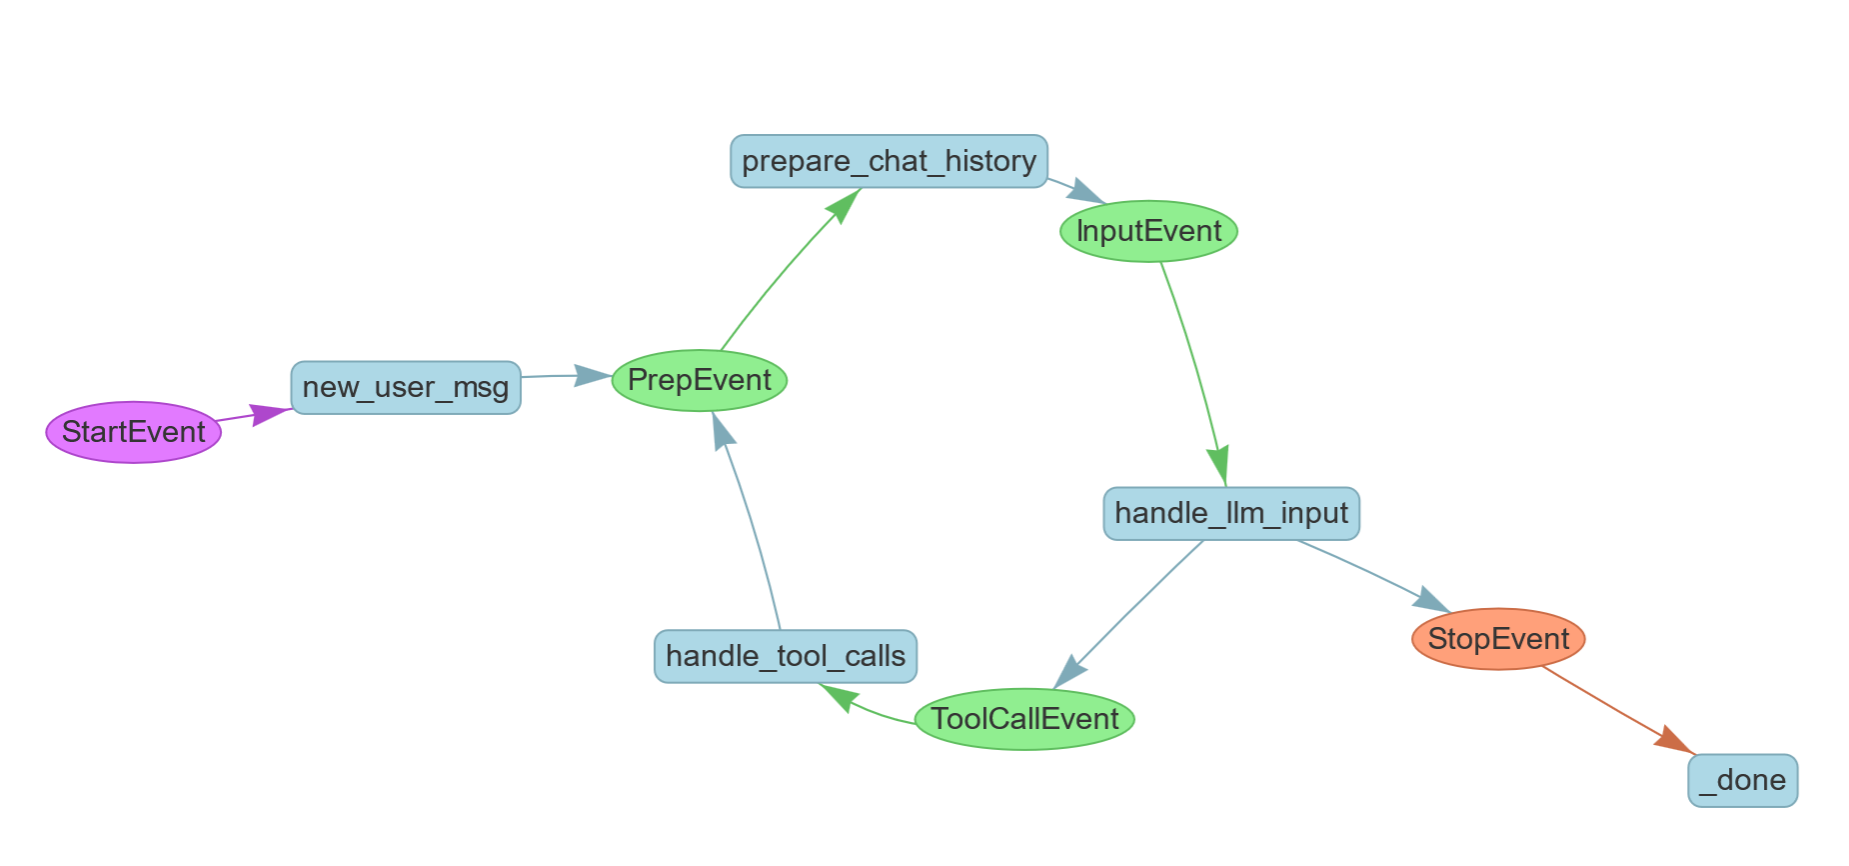

In [7]:
from IPython.display import Image
#Reference workflow we are trying to create.
Image("./datasets/Scheduling agent workflow.png")

In [8]:
from llama_index.core.llms import ChatMessage
from llama_index.core.tools import ToolSelection, ToolOutput
from llama_index.core.workflow import Event
from typing import Any, List

from llama_index.core.agent.react import ReActChatFormatter, ReActOutputParser
from llama_index.core.agent.react.types import (
    ActionReasoningStep,
    ObservationReasoningStep,
)
from llama_index.core.llms.llm import LLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.tools.types import BaseTool
from llama_index.core.workflow import (
    Context,
    Workflow,
    StartEvent,
    StopEvent,
    step,
)

#Preparation event for the request
class PrepEvent(Event):
    pass

#Input to the LLM
class InputEvent(Event):
    input: list[ChatMessage]

#Trigger tool calls
class ToolCallEvent(Event):
    tool_calls: list[ToolSelection]




### 05.05. Create the custom ReAct workflow

In [9]:
from typing import Any, List

from llama_index.core.agent.react import ReActChatFormatter, ReActOutputParser
from llama_index.core.agent.react.types import (
    ActionReasoningStep,
    ObservationReasoningStep,
)
from llama_index.core.llms.llm import LLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.tools.types import BaseTool
from llama_index.core.workflow import (
    Context,
    Workflow,
    StartEvent,
    StopEvent,
    step,
)
from llama_index.utils.workflow import draw_all_possible_flows


class SchedulingAgent(Workflow):
    def __init__(
        self,
        *args: Any,
        llm: LLM | None = None,
        tools: list[BaseTool] | None = None,
        extra_context: str | None = None,
        **kwargs: Any,
    ) -> None:
        #Call the parent class init
        super().__init__(*args, **kwargs)

        #Copy input to instance variables
        self.tools = tools
        self.llm = llm
        #Setup memory to track the request across tools
        self.memory = ChatMemoryBuffer.from_defaults(llm=llm)
        self.formatter = ReActChatFormatter(context=extra_context or "")
        self.output_parser = ReActOutputParser()
        self.sources = []

    @step
    async def new_user_msg(self, ctx: Context, ev: StartEvent) -> PrepEvent:
        # clear sources
        self.sources = []

        # get user input
        user_input = ev.input
        user_msg = ChatMessage(role="user", content=user_input)
        self.memory.put(user_msg)

        # clear current reasoning since its a new request
        await ctx.set("current_reasoning", [])

        return PrepEvent()

    @step
    async def prepare_chat_history(
        self, ctx: Context, ev: PrepEvent
    ) -> InputEvent:
        # get chat history & format input
        chat_history = self.memory.get()
        current_reasoning = await ctx.get("current_reasoning", default=[])
        llm_input = self.formatter.format(
            self.tools, chat_history,
            current_reasoning=current_reasoning
        )
        return InputEvent(input=llm_input)

    @step
    async def handle_llm_input(
        self, ctx: Context, ev: InputEvent
    ) -> ToolCallEvent | StopEvent:
        chat_history = ev.input

        #Send prompt to LLM and get response
        response = await self.llm.achat(chat_history)

        try: #Analyze the response from LLM
            reasoning_step = self.output_parser.parse(response.message.content)
            (await ctx.get("current_reasoning", default=[])).append(
                reasoning_step
            )
            print("*** LLM Returned : ", reasoning_step)
            #If LLM says that ReACt is done
            if reasoning_step.is_done:
                self.memory.put(
                    ChatMessage(
                        role="assistant", content=reasoning_step.response
                    )
                )
                return StopEvent(
                    result={
                        "response": reasoning_step.response,
                        "sources": [*self.sources],
                        "reasoning": await ctx.get(
                            "current_reasoning", default=[]
                        ),
                    }
                )
            #If LLM says that tool calling is needed
            elif isinstance(reasoning_step, ActionReasoningStep):
                tool_name = reasoning_step.action
                tool_args = reasoning_step.action_input
                return ToolCallEvent(
                    tool_calls=[
                        ToolSelection(
                            tool_id="fake",
                            tool_name=tool_name,
                            tool_kwargs=tool_args,
                        )
                    ]
                )
        except Exception as e:
            (await ctx.get("current_reasoning", default=[])).append(
                ObservationReasoningStep(
                    observation=f"There was an error in parsing my reasoning: {e}"
                )
            )

        # if no tool calls or final response, iterate again
        return PrepEvent()

    @step
    async def handle_tool_calls(
        self, ctx: Context, ev: ToolCallEvent
    ) -> PrepEvent:
        tool_calls = ev.tool_calls
        tools_by_name = {tool.metadata.get_name(): tool for tool in self.tools}

        # call tools. There may be multiple tool calls in a single step
        print("*** Calling tools : ", tool_calls)
        for tool_call in tool_calls:
            tool = tools_by_name.get(tool_call.tool_name)
            if not tool:
                (await ctx.get("current_reasoning", default=[])).append(
                    ObservationReasoningStep(
                        observation=f"Tool {tool_call.tool_name} does not exist"
                    )
                )
                continue

            try:
                #Call the tool
                tool_output = tool(**tool_call.tool_kwargs)
                self.sources.append(tool_output)
                (await ctx.get("current_reasoning", default=[])).append(
                    ObservationReasoningStep(observation=tool_output.content)
                )
            except Exception as e:
                (await ctx.get("current_reasoning", default=[])).append(
                    ObservationReasoningStep(
                        observation=f"Error calling tool {tool.metadata.get_name()}: {e}"
                    )
                )

        # prep the next iteraiton
        return PrepEvent()


In [ ]:

#draw_all_possible_flows(SchedulingAgent, filename="scheduling_agent_flow.html")

### 05.06. Create and execute the Scheduling Agent

In [10]:

#List of tools
scheduling_tools=[doctor_tool, appointment_tool]

context = """
You are a doctor scheduling assistant. You allow patients to search
for list of doctors by speciality. When a patient requests an appointement
with a specific doctor, you will also email the doctor with an appointment
request.

Use doctors tool to search for doctor by disease / specialization, get
their information including email ID.

To setup an appointment, use the schedule_appointment function passing in the
required parameters captured from user input.

Use only the tools provided to answer questions and NOT your own memory.

"""
#Create the workflow agent
scheduling_agent = SchedulingAgent(
                        llm=Settings.llm,
                        tools=scheduling_tools,
                        extra_context=context,
                        timeout=120,
                        verbose=True,
)



In [13]:
response=await scheduling_agent.run(input="Which doctors are cardiologists?")
# print("*******\n Response : ",response.get("response"))
display(Markdown(f"----\n"))
display(Markdown(f"**Response:** {response.get('response')}"))

Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
*** LLM Returned :  thought='The current language of the user is: English. I need to use a tool to help me answer the question.' action='query_engine_tool' action_input={'input': 'cardiologist'}
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
*** Calling tools :  [ToolSelection(tool_id='fake', tool_name='query_engine_tool', tool_kwargs={'input': 'cardiologist'})]
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
*** LLM Returned :  thought="I can answer without using any more tools. I'll use the user's language to answer." response='Dr. John Smith is a cardiologist with 15 years of experience.' is_streaming=False
Step handle_llm_input produced event StopEvent

----


**Response:** Dr. John Smith is a cardiologist with 15 years of experience.

In [14]:
response=await scheduling_agent.run(input=
    "Please setup an appointment with John Smith for Ben Jones next week in the afternoons")
# print("*******\n Response : ",response.get("response"))
display(Markdown(f"----\n"))
display(Markdown(f"**Response:** {response.get('response')}"))

Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
*** LLM Returned :  thought='I need to use a tool to schedule an appointment with Dr. John Smith for Ben Jones next week in the afternoons.' action='schedule_appointment' action_input={'patient_name': 'Ben Jones', 'doctor_name': 'John Smith', 'scheduling_comments': 'Requesting an appointment next week in the afternoons.'}
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
*** Calling tools :  [ToolSelection(tool_id='fake', tool_name='schedule_appointment', tool_kwargs={'patient_name': 'Ben Jones', 'doctor_name': 'John Smith', 'scheduling_comments': 'Requesting an appointment next week in the afternoons.'})]
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
*** L

----


**Response:** The appointment with Dr. John Smith for Ben Jones has been successfully scheduled for next week in the afternoons.

In [15]:
response=await scheduling_agent.run(input=
    "Find a neurologist and request an appointment for Beth Wilson at the earliest")
# print("*******\n Response : ",response.get("response"))
display(Markdown(f"----\n"))
display(Markdown(f"**Response:** {response.get('response')}"))

Running step new_user_msg
Step new_user_msg produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
*** LLM Returned :  thought='I need to find a neurologist to request an appointment for Beth Wilson.' action='query_engine_tool' action_input={'input': 'Find a neurologist'}
Step handle_llm_input produced event ToolCallEvent
Running step handle_tool_calls
*** Calling tools :  [ToolSelection(tool_id='fake', tool_name='query_engine_tool', tool_kwargs={'input': 'Find a neurologist'})]
Step handle_tool_calls produced event PrepEvent
Running step prepare_chat_history
Step prepare_chat_history produced event InputEvent
Running step handle_llm_input
*** LLM Returned :  thought='I found a neurologist, Dr. Michael Brown. Now I will request an appointment for Beth Wilson at the earliest.' action='schedule_appointment' action_input={'patient_name': 'Beth Wilson', 'doctor_name': 'Dr. Michael Brown', 'scheduling_comm

----


**Response:** An appointment has been successfully scheduled for Beth Wilson with Dr. Michael Brown at the earliest available time.